In [25]:
from netCDF4 import Dataset
from cartoplot import cartoplot
import numpy as np
import datetime
from pyproj import Proj, transform
from scipy.spatial.kdtree import KDTree
import pandas as pd
import matplotlib.pyplot as plt
from ll_xy import lonlat_to_xy
import cartopy.crs as ccrs
import cartopy
import pickle
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import numpy as np
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd


In [26]:
pmw_f = 'ice_conc_sh_polstere-100_multi_202204221200.nc'
pmw_d = Dataset(f'../data/OSISAF_pmw/{pmw_f}')
pmw_lon = np.array(pmw_d['lon'])
pmw_lat = np.array(pmw_d['lat'])

In [37]:
floes_df = pd.read_csv('../data/floe_coords.csv',parse_dates=['dt'])

dates = [dt.date() for dt in floes_df['dt']]

In [28]:
ddir = '../data/OSISAF_imv/'

def get_date_str(date):

    day = date.day
    month = date.month
    year = date.year
    
    date_str = f'{year}{str(month).zfill(2)}{str(day).zfill(2)}'
    
    return date_str

def get_imv_on_date(date):

    d1 = get_date_str(date-datetime.timedelta(days=1))
    d2 = get_date_str(date+datetime.timedelta(days=1))
    
    floc = f'{ddir}ice_drift_sh_polstere-625_multi-oi_{d1}1200-{d2}1200.nc'
    
    d = Dataset(floc)

    return d



In [29]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3409')
pmw_x,pmw_y = transform(inProj,outProj,pmw_lon,pmw_lat)
pmw_tree = KDTree(list(zip(pmw_x.ravel(),pmw_y.ravel())))

def check_landice(x,y):
    
    dist, ind = pmw_tree.query((x,y))

    unraveled = np.unravel_index(ind, pmw_x.shape)

    land_ice_data = np.array(pmw_d['ice_conc'][0])[unraveled]
    
    if land_ice_data == -999:
        
        return True
    
    else:
        
        return False

/home/robbie/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/robbie/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When 

In [30]:

d = get_imv_on_date(dates[-1])
imv_lons = np.array(d['lon'])
imv_lats = np.array(d['lat'])

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3409')
x,y = transform(inProj,outProj,imv_lons,imv_lats)
tree = KDTree(list(zip(x.ravel(),y.ravel())))

dx_last_day = np.array(d['dX'][0])

dx_last_day[dx_last_day<-10_000] = np.nan

/home/robbie/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/robbie/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When 

In [31]:
dfs = []

for date, lon, lat in zip(dates,df['lon'],df['lat']):
    
    print(date)

    # Find position
    
    current_date = date

    x,y = transform(inProj,outProj,lon,lat)

    list_of_dicts = []
    
    dx= 1
    
    while dx < 10_00000:
        

        # Get nearest vectors
    
        dist, ind = tree.query((x,y))
        
        unraveled = np.unravel_index(ind, imv_lons.shape)

        d = get_imv_on_date(current_date)

        dx = -int(np.array(d['dX'])[0][unraveled]*1000/2)
        dy = -int(np.array(d['dY'])[0][unraveled]*1000/2)
        
        if dx > 10_00000:
            
            dxdata = np.array(d['dX'][0])
            dydata = np.array(d['dY'][0])
            dxdata[dxdata<-10_000] = np.nan
            
            
            imv_lons_c = imv_lons[~np.isnan(dxdata)]
            imv_lats_c = imv_lats[~np.isnan(dxdata)]
            dydata_c = dydata[~np.isnan(dxdata)]
            dxdata_c = dxdata[~np.isnan(dxdata)]
            
            x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)
            tree_c = KDTree(list(zip(x_c.ravel(),y_c.ravel())))
            
            dist, ind = tree_c.query((x,y))
        
            dx = -int(dxdata_c[ind]*1000/2)
            dy = -int(dydata_c[ind]*1000/2)
            
        x = x + dx
        y = y + dy
        current_date = current_date - datetime.timedelta(days=1)

        list_of_dicts.append({'date':current_date,
                               'dx':dx,
                               'dy':dy,
                               'distance':dist,
                               'x':x,
                               'y':y})
        
        if dist > 200_000:
            break
            
        if current_date == datetime.date(2021,1,1):
            break
            
        if check_landice(x,y) == True:
            
            break

        
    df = pd.DataFrame(list_of_dicts)
    
    df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])
    
    dfs.append(df)
    

2022-04-11


/tmp/ipykernel_32379/2106028257.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,lon,lat)
/tmp/ipykernel_32379/2106028257.py:43: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)
/tmp/ipykernel_32379/2106028257.py:75: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])


2022-04-16
2022-04-17
2022-04-19
2022-04-22


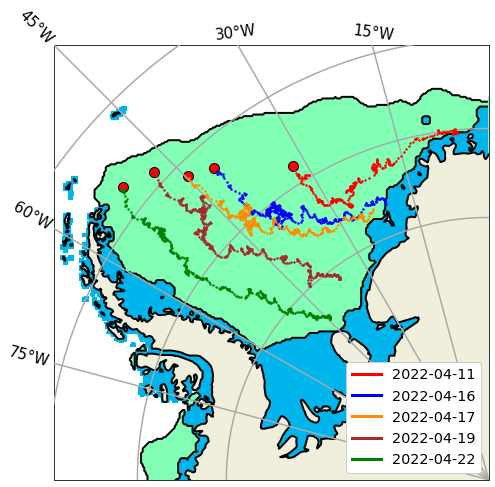

In [59]:


pmw_data = pmw_d['ice_conc'][0].copy()
pmw_data[pmw_data>0.5] = 2
pmw_data[pmw_data<0] = 1
pmw_data[pmw_data<0.5] = np.nan



# Make plot

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=9,linewidth=2)

ax.set_extent([-80, -10, -90, -65], ccrs.PlateCarree())

scat = ax.scatter(floes_df['lon'],
                  floes_df['lat'],
                  transform=ccrs.PlateCarree(),
                  marker='o',
                  color='r',
                  edgecolor='k',
                  s=100,
                  zorder=9,)



colors = ['r','b','darkorange','brown','green']    

for df_traj, date, color in zip(dfs,dates,colors):

    scat = ax.scatter(df_traj['lon'],
                      df_traj['lat'],
                      c=color,
#                       c='r',
                      transform=ccrs.PlateCarree(),
                      marker='o',
                      s=2,
                      zorder=15)
    
    ax.plot([],[],color=color,label=date,lw=3)

###################################

lon2d_greater = ma.masked_greater(np.array(pmw_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(pmw_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(np.array(pmw_d['ice_conc'][0]), mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(np.array(pmw_d['ice_conc'][0]), mask=lon2d_greater.mask)


cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0],
                  transform=ccrs.PlateCarree(),
                  zorder=6,
                    linewidths=[2],
                  colors=['k'])


##################################


mesh = ax.pcolormesh(pmw_lon,pmw_lat,
                     pmw_data,
                         cmap='rainbow',
                     transform=ccrs.PlateCarree(),
                    vmin=0,vmax=4,zorder=5)

gl = ax.gridlines(zorder=10,color='darkgrey',linewidth=1.5)
gl.xlabel_style = {'size': 15, 'color': 'k'}

gl.ylocator = mticker.FixedLocator(np.arange(-60,-80,-5))
gl.xlocator = mticker.FixedLocator(np.arange(0,-91,-15))

gl.ylabels_left = True
gl.xlabels_top = True


plt.legend(loc='lower right',fontsize='x-large',facecolor='white',framealpha=1).set_zorder(102) 


plt.savefig('../figures/floe_trajectories.jpg',dpi=400,bbox_inches='tight')

plt.show()



In [48]:
for df, date in zip(dfs, dates):
    
    df.to_csv(f'../data/{date}-trajectory.csv')

In [49]:
df

,date,dx,dy,distance,x,y,lon,lat
0,2022-04-21,5238,-8574,29403.834241,-2.274204e+06,1.811959e+06,-51.454108,-63.618181
1,2022-04-20,4677,-6447,23290.129528,-2.269527e+06,1.805512e+06,-51.496146,-63.689063
2,2022-04-19,-10519,-1393,20129.506037,-2.280046e+06,1.804119e+06,-51.646681,-63.620951
3,2022-04-18,-7344,529,30499.164134,-2.287390e+06,1.804648e+06,-51.728137,-63.564694
4,2022-04-17,576,-907,25119.233034,-2.286814e+06,1.803741e+06,-51.735127,-63.574061
...,...,...,...,...,...,...,...,...
471,2021-01-05,865,-1126,11151.458285,-1.009761e+06,1.024877e+06,-44.574322,-77.033858
472,2021-01-04,618,-1116,11372.035716,-1.009143e+06,1.023761e+06,-44.587994,-77.044978
473,2021-01-03,698,76,11530.021907,-1.008445e+06,1.023837e+06,-44.566048,-77.048922
474,2021-01-02,1544,266,12216.473394,-1.006901e+06,1.024103e+06,-44.514717,-77.057008
